In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from tensorflow.keras.utils  import to_categorical
import tensorflow as tf
import pickle

In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=7144)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_rand():
    X=[]
    dir_path='dataset/train'
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(100,100))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X

In [4]:
X=load_rand()


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 47.37it/s]

freshapples
freshbanana
freshoranges
rottenapples
rottenbanana
rottenoranges


In [5]:
X=np.array(X)
X.shape

(36, 100, 100, 3)

In [6]:
def show_subpot(X,title=False,Y=None):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(40,60))
        list_fruits=['rottenoranges', 'rottenapples', 'freshbanana', 'freshoranges', 'rottenbanana', 'freshapples']
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            if title==False:
                ax[i//6][i%6].set_title(list_fruits[i//6])
            elif title and Y is not None:
                ax[i//6][i%6].set_title(Y[i])
        plt.show()
    else:
        print('Cannot plot')

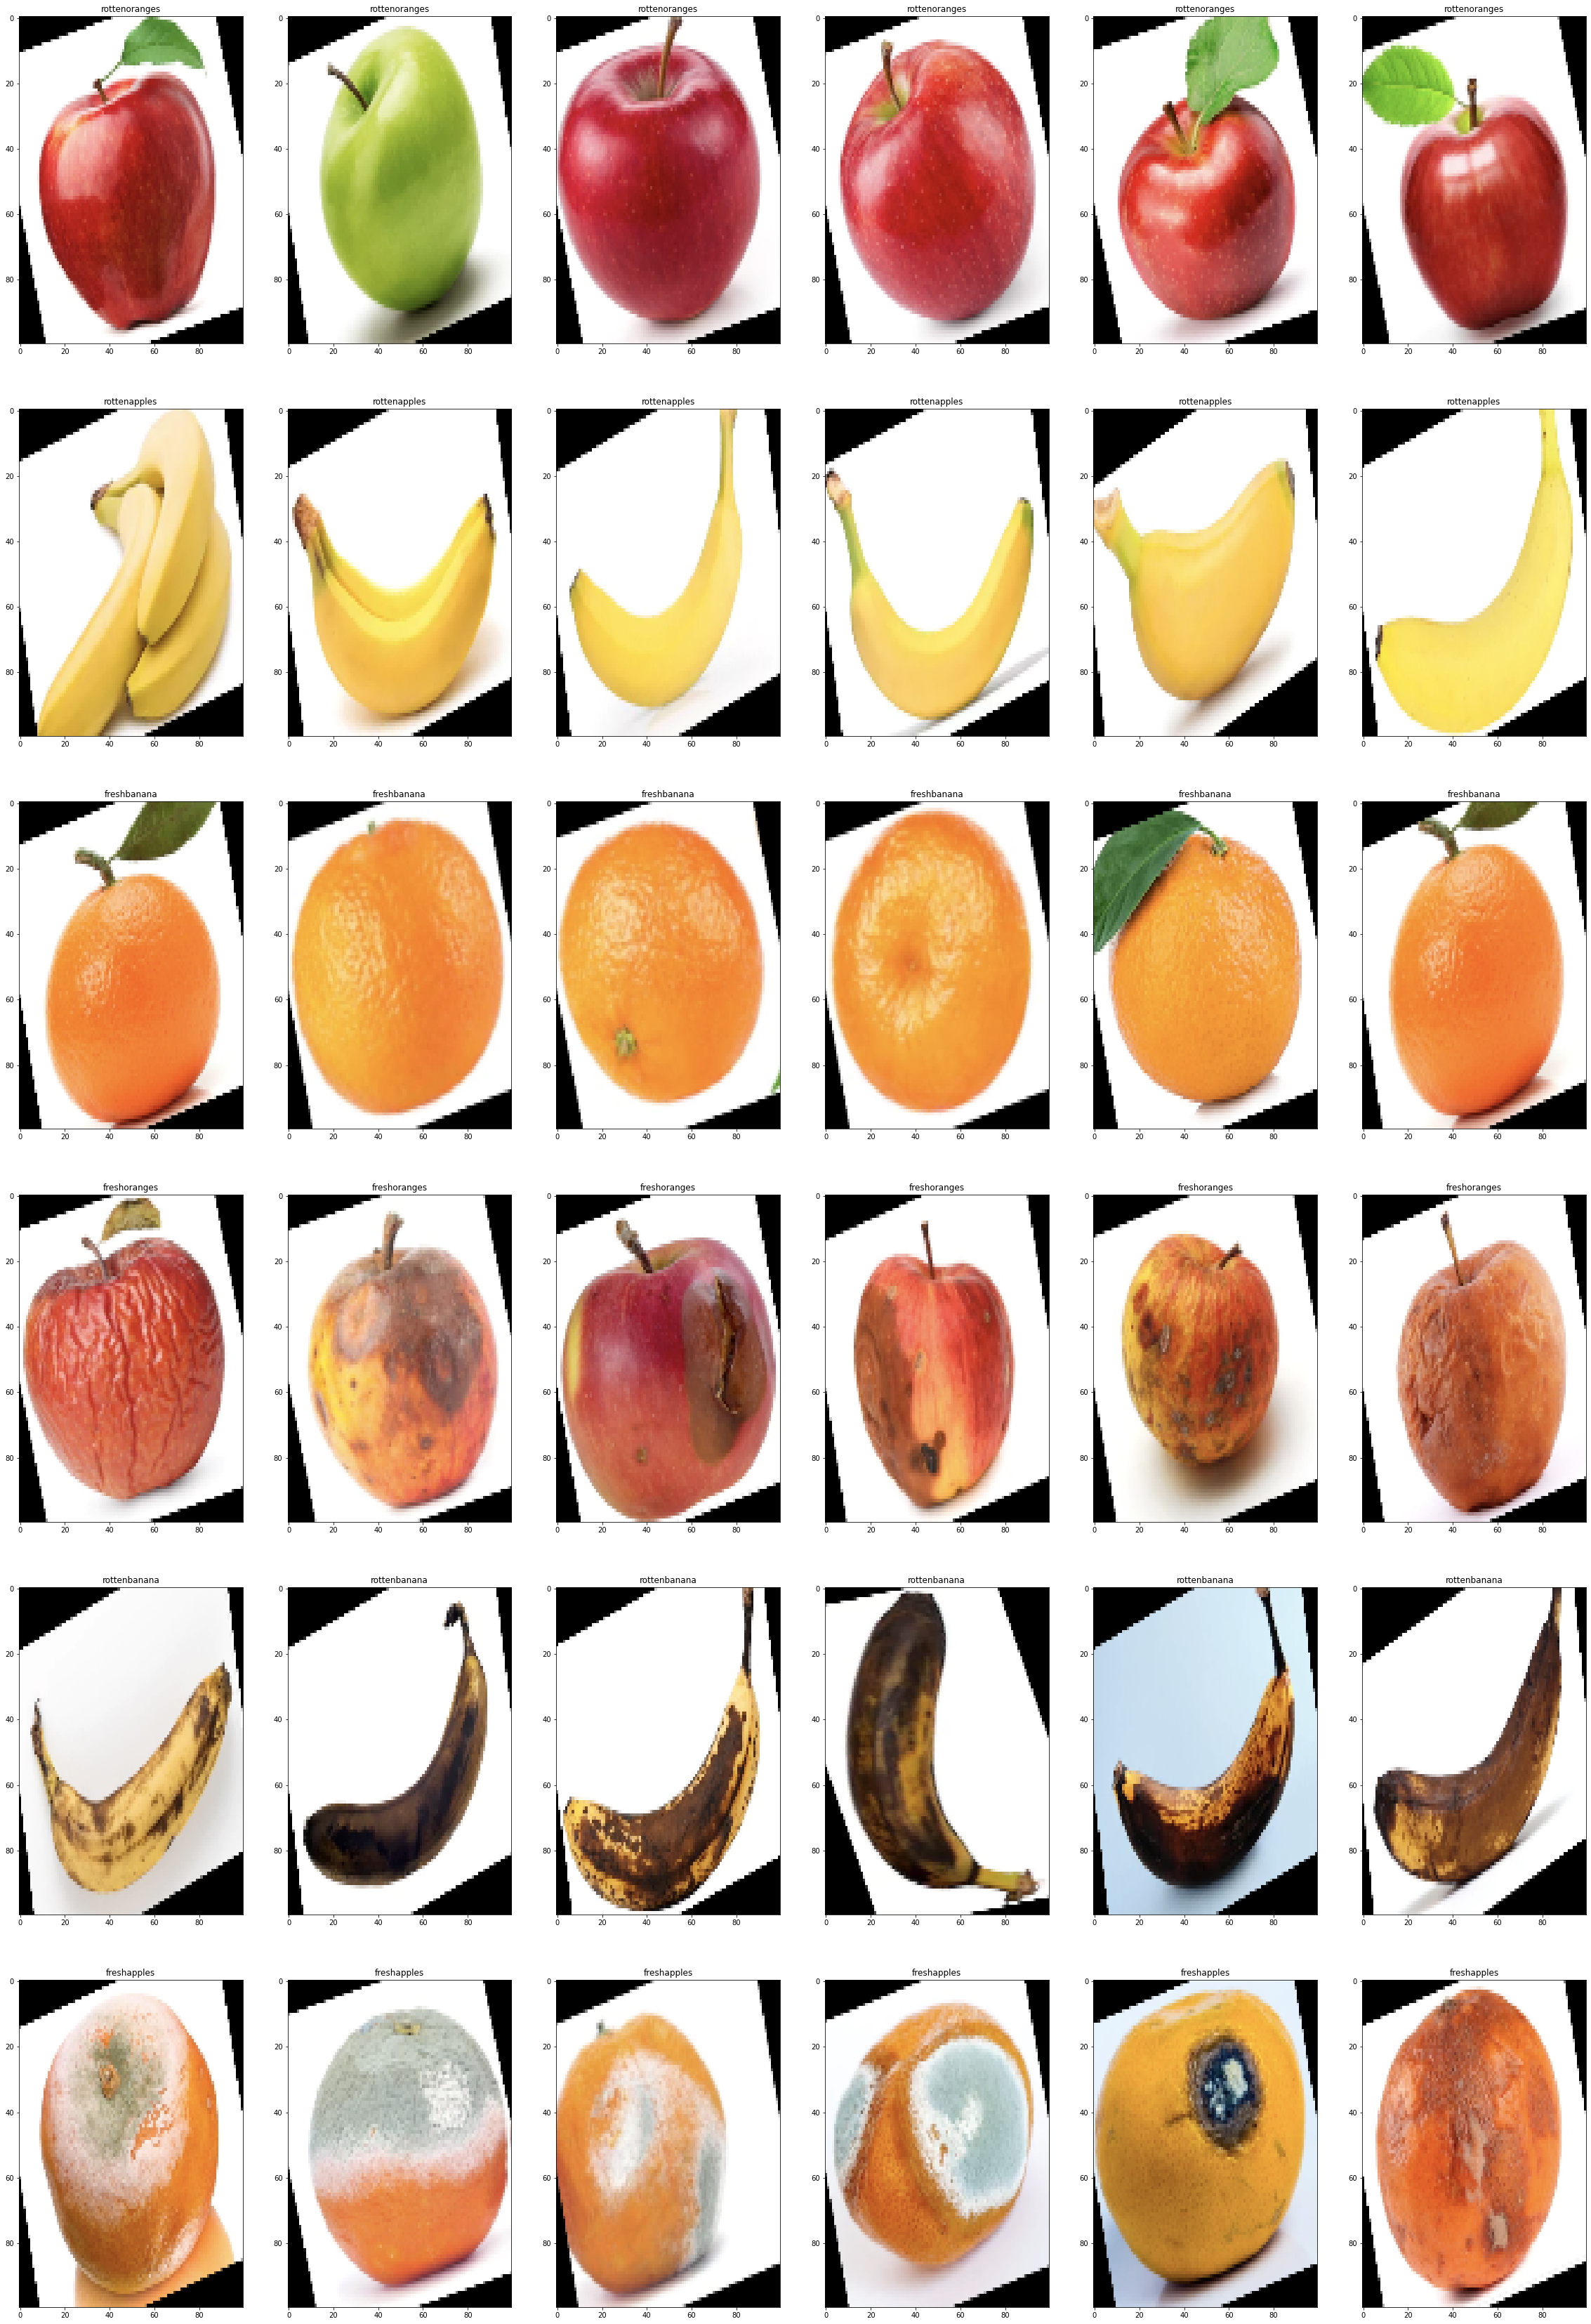

In [7]:
show_subpot(X)

In [8]:
del X

In [9]:
def load_rottenvsfresh():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])

    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [10]:
X,Y=load_rottenvsfresh()

100%|███████████████████████████████████████████████████████████████████████| 10901/10901 [00:00<00:00, 1821815.67it/s]


In [11]:
Y=np.array(Y)
X=np.array(X)

In [12]:
y_ser=pd.Series(Y)
y_ser.value_counts()

1    6161
0    4740
dtype: int64

In [13]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y  

In [14]:
X_val,Y_val=load_rottenvsfresh_valset()

100%|█████████████████████████████████████████████████████████████████████████| 2698/2698 [00:00<00:00, 1352322.20it/s]


In [15]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

In [16]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 separable_conv2d (Separable  (None, 100, 100, 32)     1344      
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 32)       128       
 hNormalization)                                        

In [19]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='rotten.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

C:\Users\moham\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
X=X/255.0
X_val=X_val/255.0

In [21]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 50,
                 callbacks=[check_point])

Epoch 1/50
546/546 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.8698
Epoch 1: val_loss improved from inf to 3.16116, saving model to rotten.h5
546/546 [==============================] - 32s 47ms/step - loss: 0.3737 - accuracy: 0.8698 - val_loss: 3.1612 - val_accuracy: 0.8232
Epoch 2/50
546/546 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9245
Epoch 2: val_loss improved from 3.16116 to 0.17236, saving model to rotten.h5
546/546 [==============================] - 25s 46ms/step - loss: 0.2097 - accuracy: 0.9245 - val_loss: 0.1724 - val_accuracy: 0.9552
Epoch 3/50
545/546 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9469
Epoch 3: val_loss improved from 0.17236 to 0.14785, saving model to rotten.h5
546/546 [==============================] - 27s 50ms/step - loss: 0.1448 - accuracy: 0.9469 - val_loss: 0.1478 - val_accuracy: 0.9548
Epoch 4/50
545/546 [============================>.] - ETA: 0s - loss: 0.1237 - accu

545/546 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9909
Epoch 29: val_loss improved from 0.02657 to 0.02015, saving model to rotten.h5
546/546 [==============================] - 84s 155ms/step - loss: 0.0298 - accuracy: 0.9909 - val_loss: 0.0202 - val_accuracy: 0.9930
Epoch 30/50
545/546 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9890
Epoch 30: val_loss did not improve from 0.02015
546/546 [==============================] - 85s 155ms/step - loss: 0.0369 - accuracy: 0.9889 - val_loss: 0.3038 - val_accuracy: 0.9162
Epoch 31/50
545/546 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9807
Epoch 31: val_loss did not improve from 0.02015
546/546 [==============================] - 85s 156ms/step - loss: 0.0568 - accuracy: 0.9807 - val_loss: 0.0276 - val_accuracy: 0.9907
Epoch 32/50
545/546 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9891
Epoch 32: val_loss did not improve from 0.02015

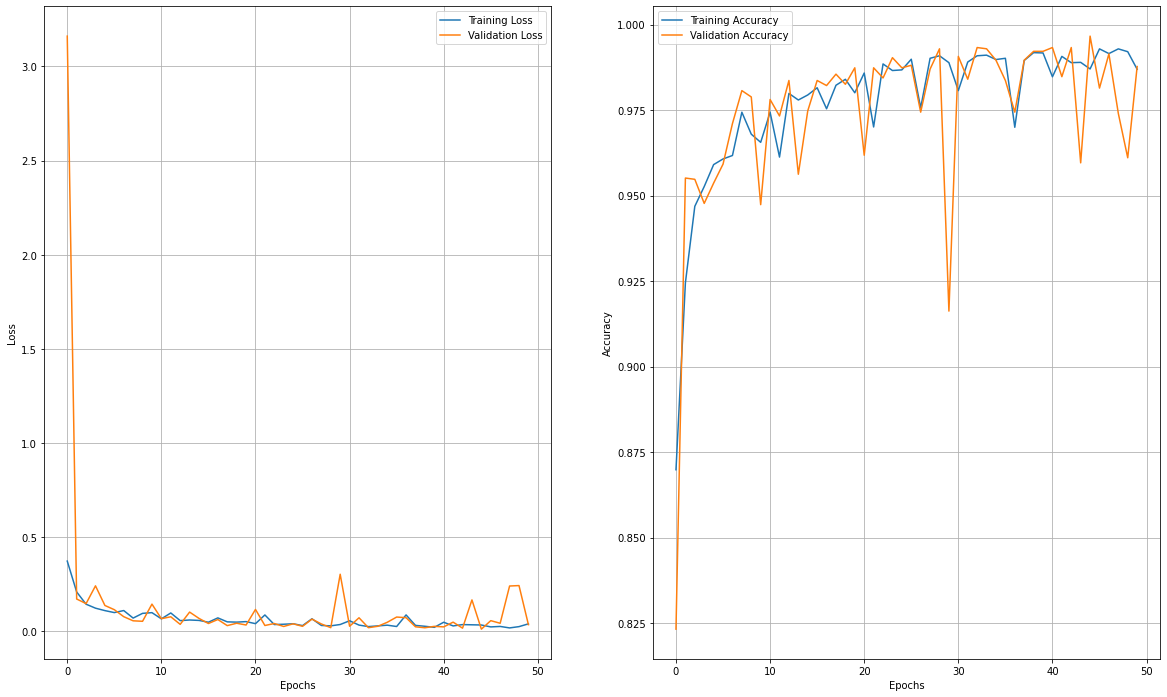

In [22]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [23]:
model.evaluate(X_val,Y_val)

85/85 [==============================] - 5s 51ms/step - loss: 0.0361 - accuracy: 0.9878


[0.03607229143381119, 0.9877687096595764]

In [24]:
model.save('rottenvsfresh.h5')

In [25]:
from keras.models import Model, load_model

In [26]:
new_model=load_model('rottenvsfresh.h5')

In [27]:
new_model.evaluate(X_val,Y_val)


85/85 [==============================] - 4s 45ms/step - loss: 0.0361 - accuracy: 0.9878


[0.03607229143381119, 0.9877687096595764]

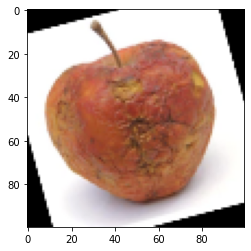

In [28]:
plt.imshow(X_val[0])


In [29]:
model.predict(X_val[0].reshape(1,100,100,3))

array([[1.]], dtype=float32)

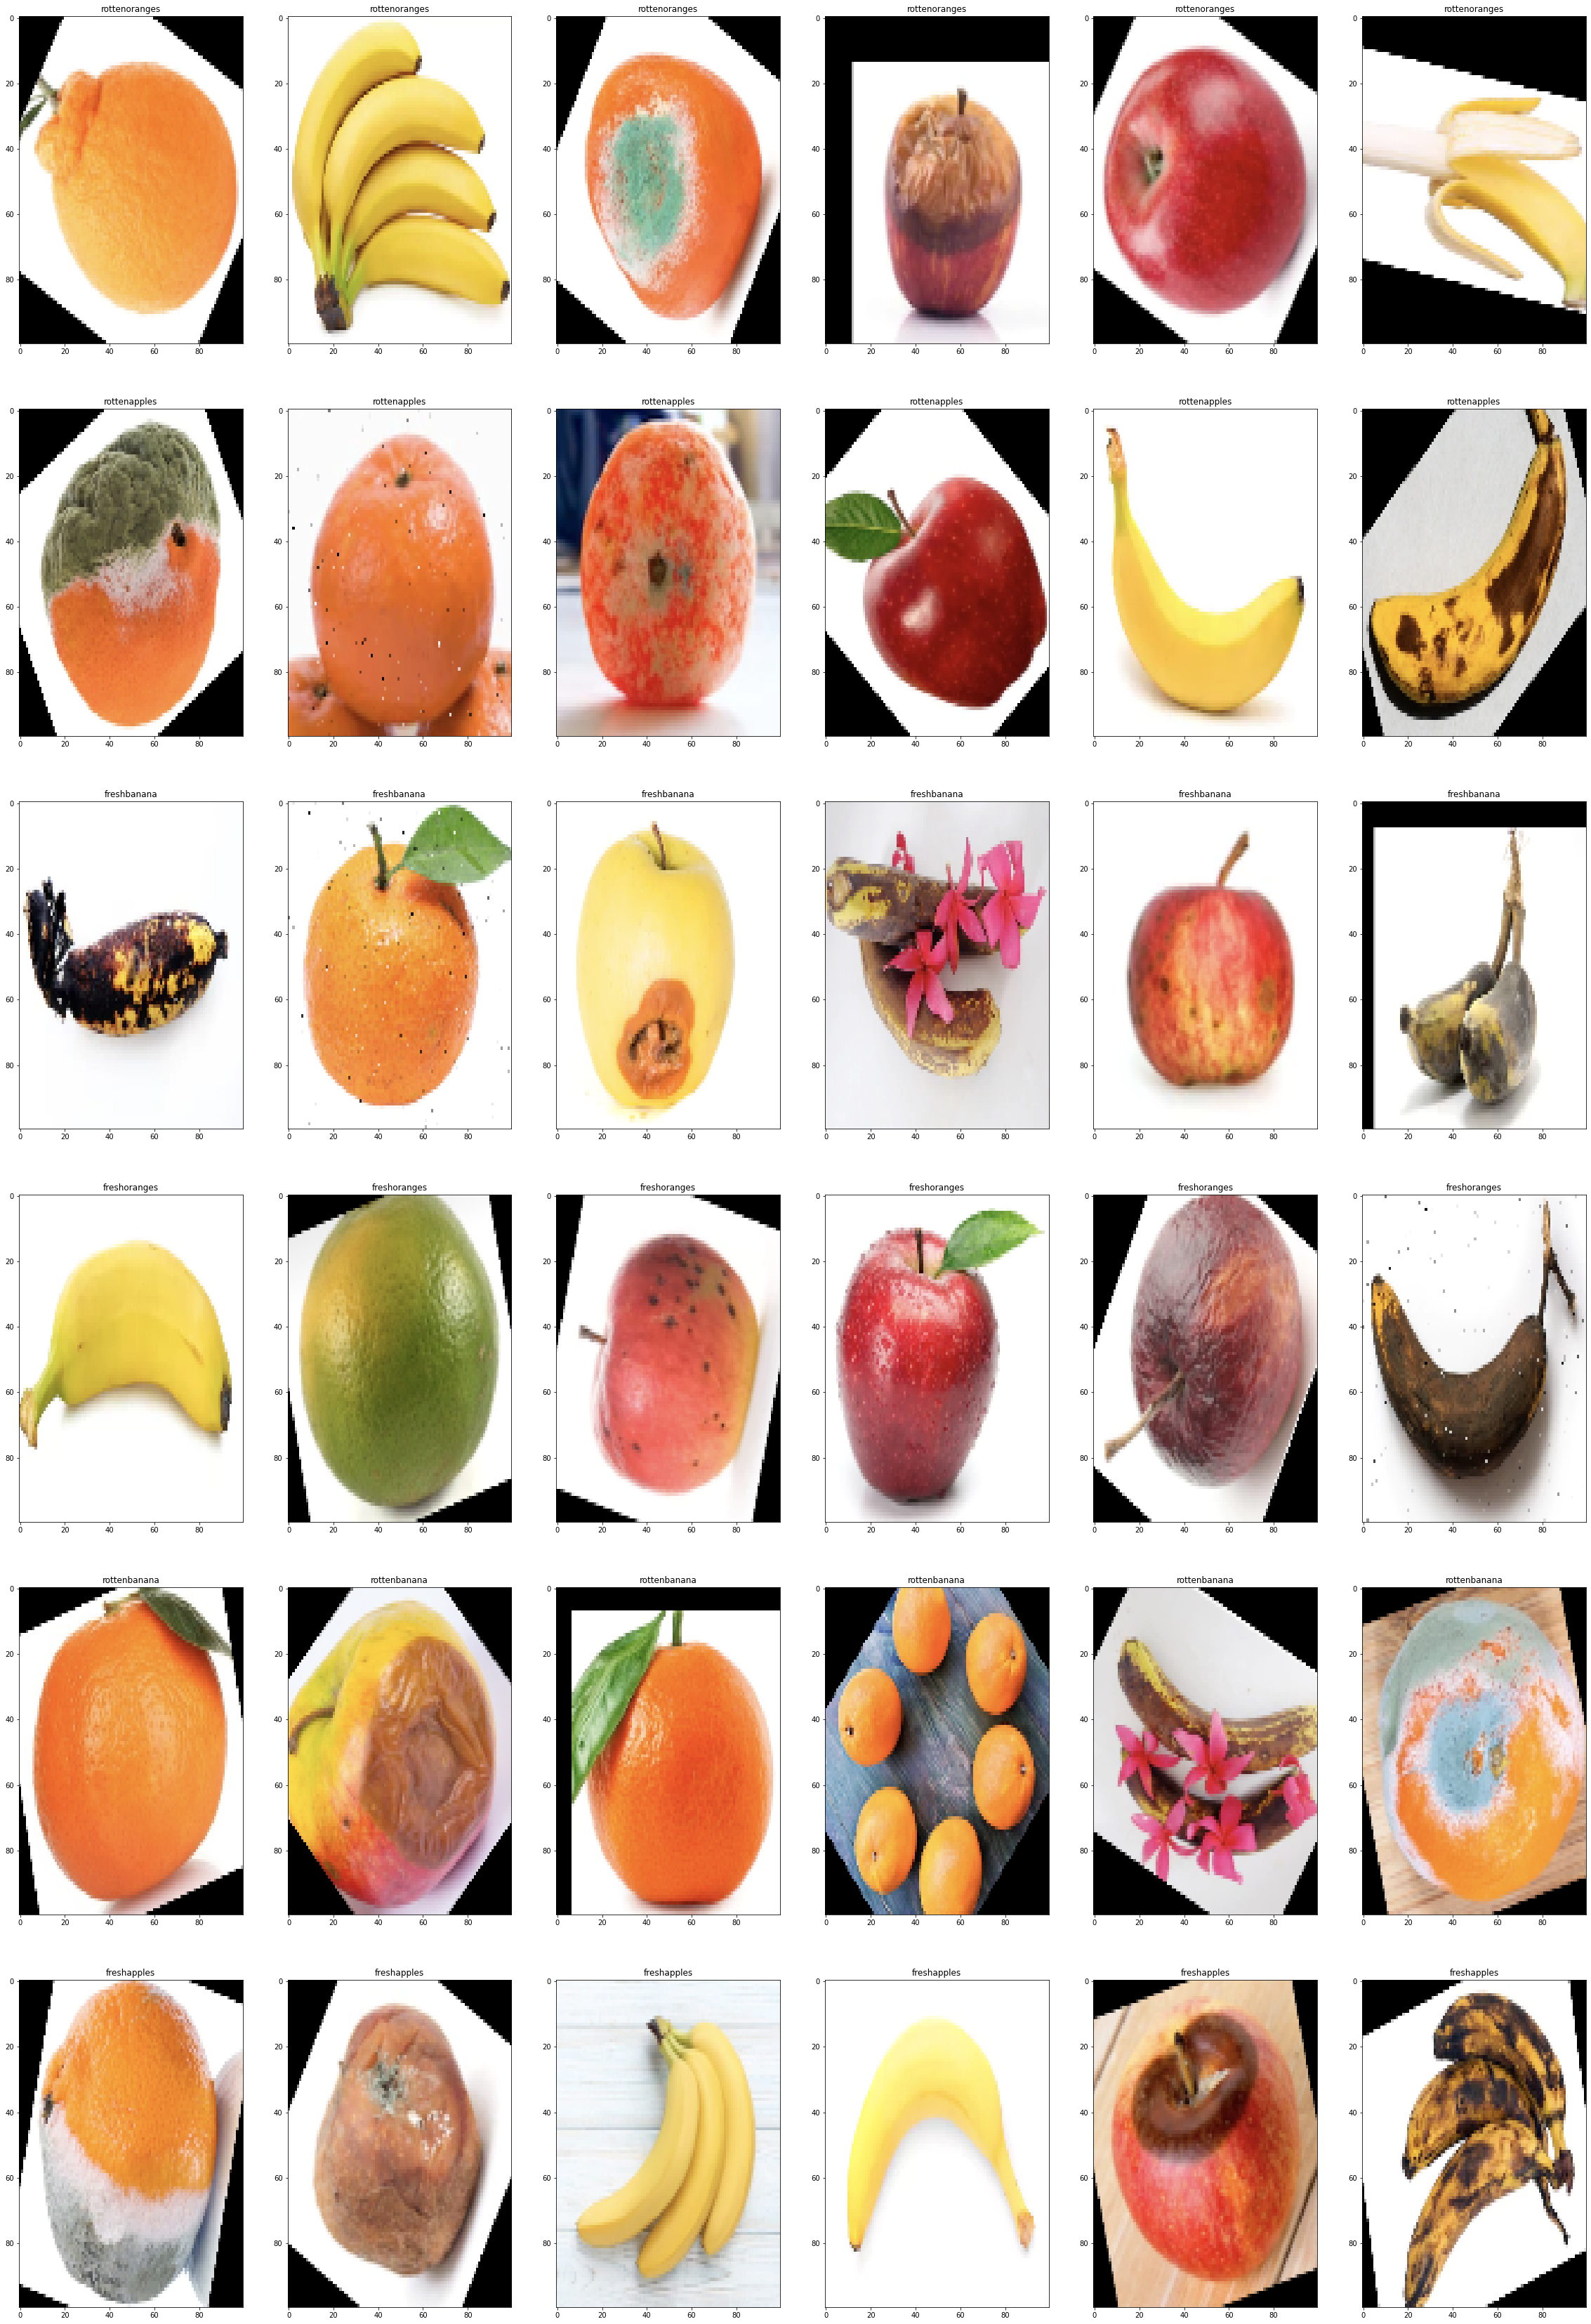

In [30]:
show_subpot(X_val[-36*11:-36*10])

In [43]:
np.argmax((model.predict(X_val[-36*11:-36*10])), axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [32]:
def load_fruits_data():
    quality=['apples', 'banana','oranges']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('dataset/test')):
        if quality[0] in cata:
            path_main=os.path.join('dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[2] in cata:
            path_main=os.path.join('dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2])
        
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 
    
def load_fruits_train_data():
    quality=['apples', 'banana','oranges']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[2] in cata:
            path_main=os.path.join('dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2])
        
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 
    

In [33]:
X_val,Y_val=load_fruits_data()

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.59s/it]


Shuffling your data.....


100%|█████████████████████████████████████████████████████████████████████████| 2698/2698 [00:00<00:00, 1352160.62it/s]


In [34]:
X,Y=load_fruits_train_data()


100%|███████████████████████████████████████████████████████████████████████| 10901/10901 [00:00<00:00, 2171968.45it/s]


In [35]:
X=np.array(X)
X_val=np.array(X_val)

In [36]:
X.shape,X_val.shape

((10901, 100, 100, 3), (2698, 100, 100, 3))

In [37]:
X=X/255.0
X_val=X_val/255.0

In [38]:
Y=to_categorical(Y)
Y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [39]:
Y_test=to_categorical(Y_val)
Y_val=np.array(Y_val)

In [40]:
Y.shape,Y_test.shape, Y_val.shape

((10901, 3), (2698, 3), (2698,))

In [41]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

In [44]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='fruit_cata.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [45]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_test),epochs= 40,
                 callbacks=[check_point])

Epoch 1/40
546/546 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8811
Epoch 1: val_loss improved from inf to 1.11929, saving model to fruit_cata.h5
546/546 [==============================] - 30s 53ms/step - loss: 0.3211 - accuracy: 0.8811 - val_loss: 1.1193 - val_accuracy: 0.3384
Epoch 2/40
546/546 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9383
Epoch 2: val_loss improved from 1.11929 to 0.16771, saving model to fruit_cata.h5
546/546 [==============================] - 28s 52ms/step - loss: 0.1860 - accuracy: 0.9383 - val_loss: 0.1677 - val_accuracy: 0.9422
Epoch 3/40
545/546 [============================>.] - ETA: 0s - loss: 0.1559 - accuracy: 0.9448
Epoch 3: val_loss improved from 0.16771 to 0.13305, saving model to fruit_cata.h5
546/546 [==============================] - 29s 54ms/step - loss: 0.1561 - accuracy: 0.9447 - val_loss: 0.1330 - val_accuracy: 0.9596
Epoch 4/40
545/546 [============================>.] - ETA: 0s - loss: 0

546/546 [==============================] - 61s 111ms/step - loss: 0.0396 - accuracy: 0.9869 - val_loss: 0.0336 - val_accuracy: 0.9915
Epoch 30/40
545/546 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9838
Epoch 30: val_loss did not improve from 0.03360
546/546 [==============================] - 48s 88ms/step - loss: 0.0570 - accuracy: 0.9838 - val_loss: 0.0811 - val_accuracy: 0.9744
Epoch 31/40
545/546 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9829
Epoch 31: val_loss did not improve from 0.03360
546/546 [==============================] - 51s 93ms/step - loss: 0.0579 - accuracy: 0.9829 - val_loss: 0.1621 - val_accuracy: 0.9644
Epoch 32/40
545/546 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9847
Epoch 32: val_loss did not improve from 0.03360
546/546 [==============================] - 90s 164ms/step - loss: 0.0467 - accuracy: 0.9847 - val_loss: 0.0474 - val_accuracy: 0.9867
Epoch 33/40
545/546 [==========

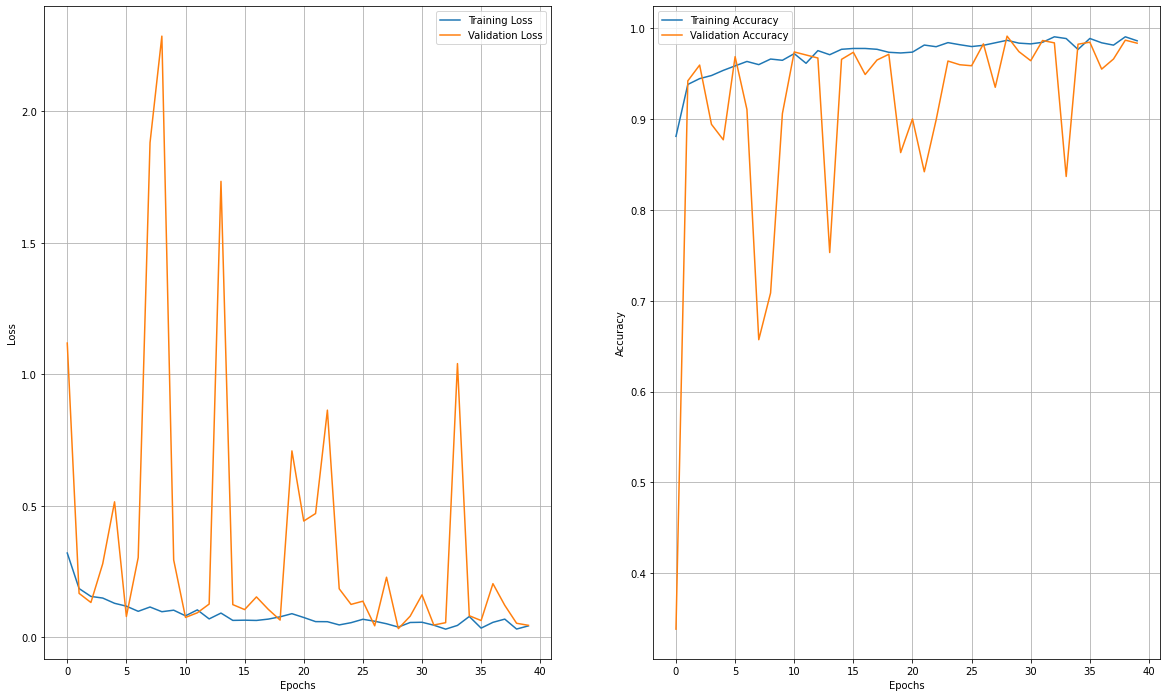

In [46]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [47]:
model=load_model('fruit_cata.h5')
model.evaluate(X,Y)

341/341 [==============================] - 5s 13ms/step - loss: 0.0152 - accuracy: 0.9956


[0.015157220885157585, 0.995596706867218]

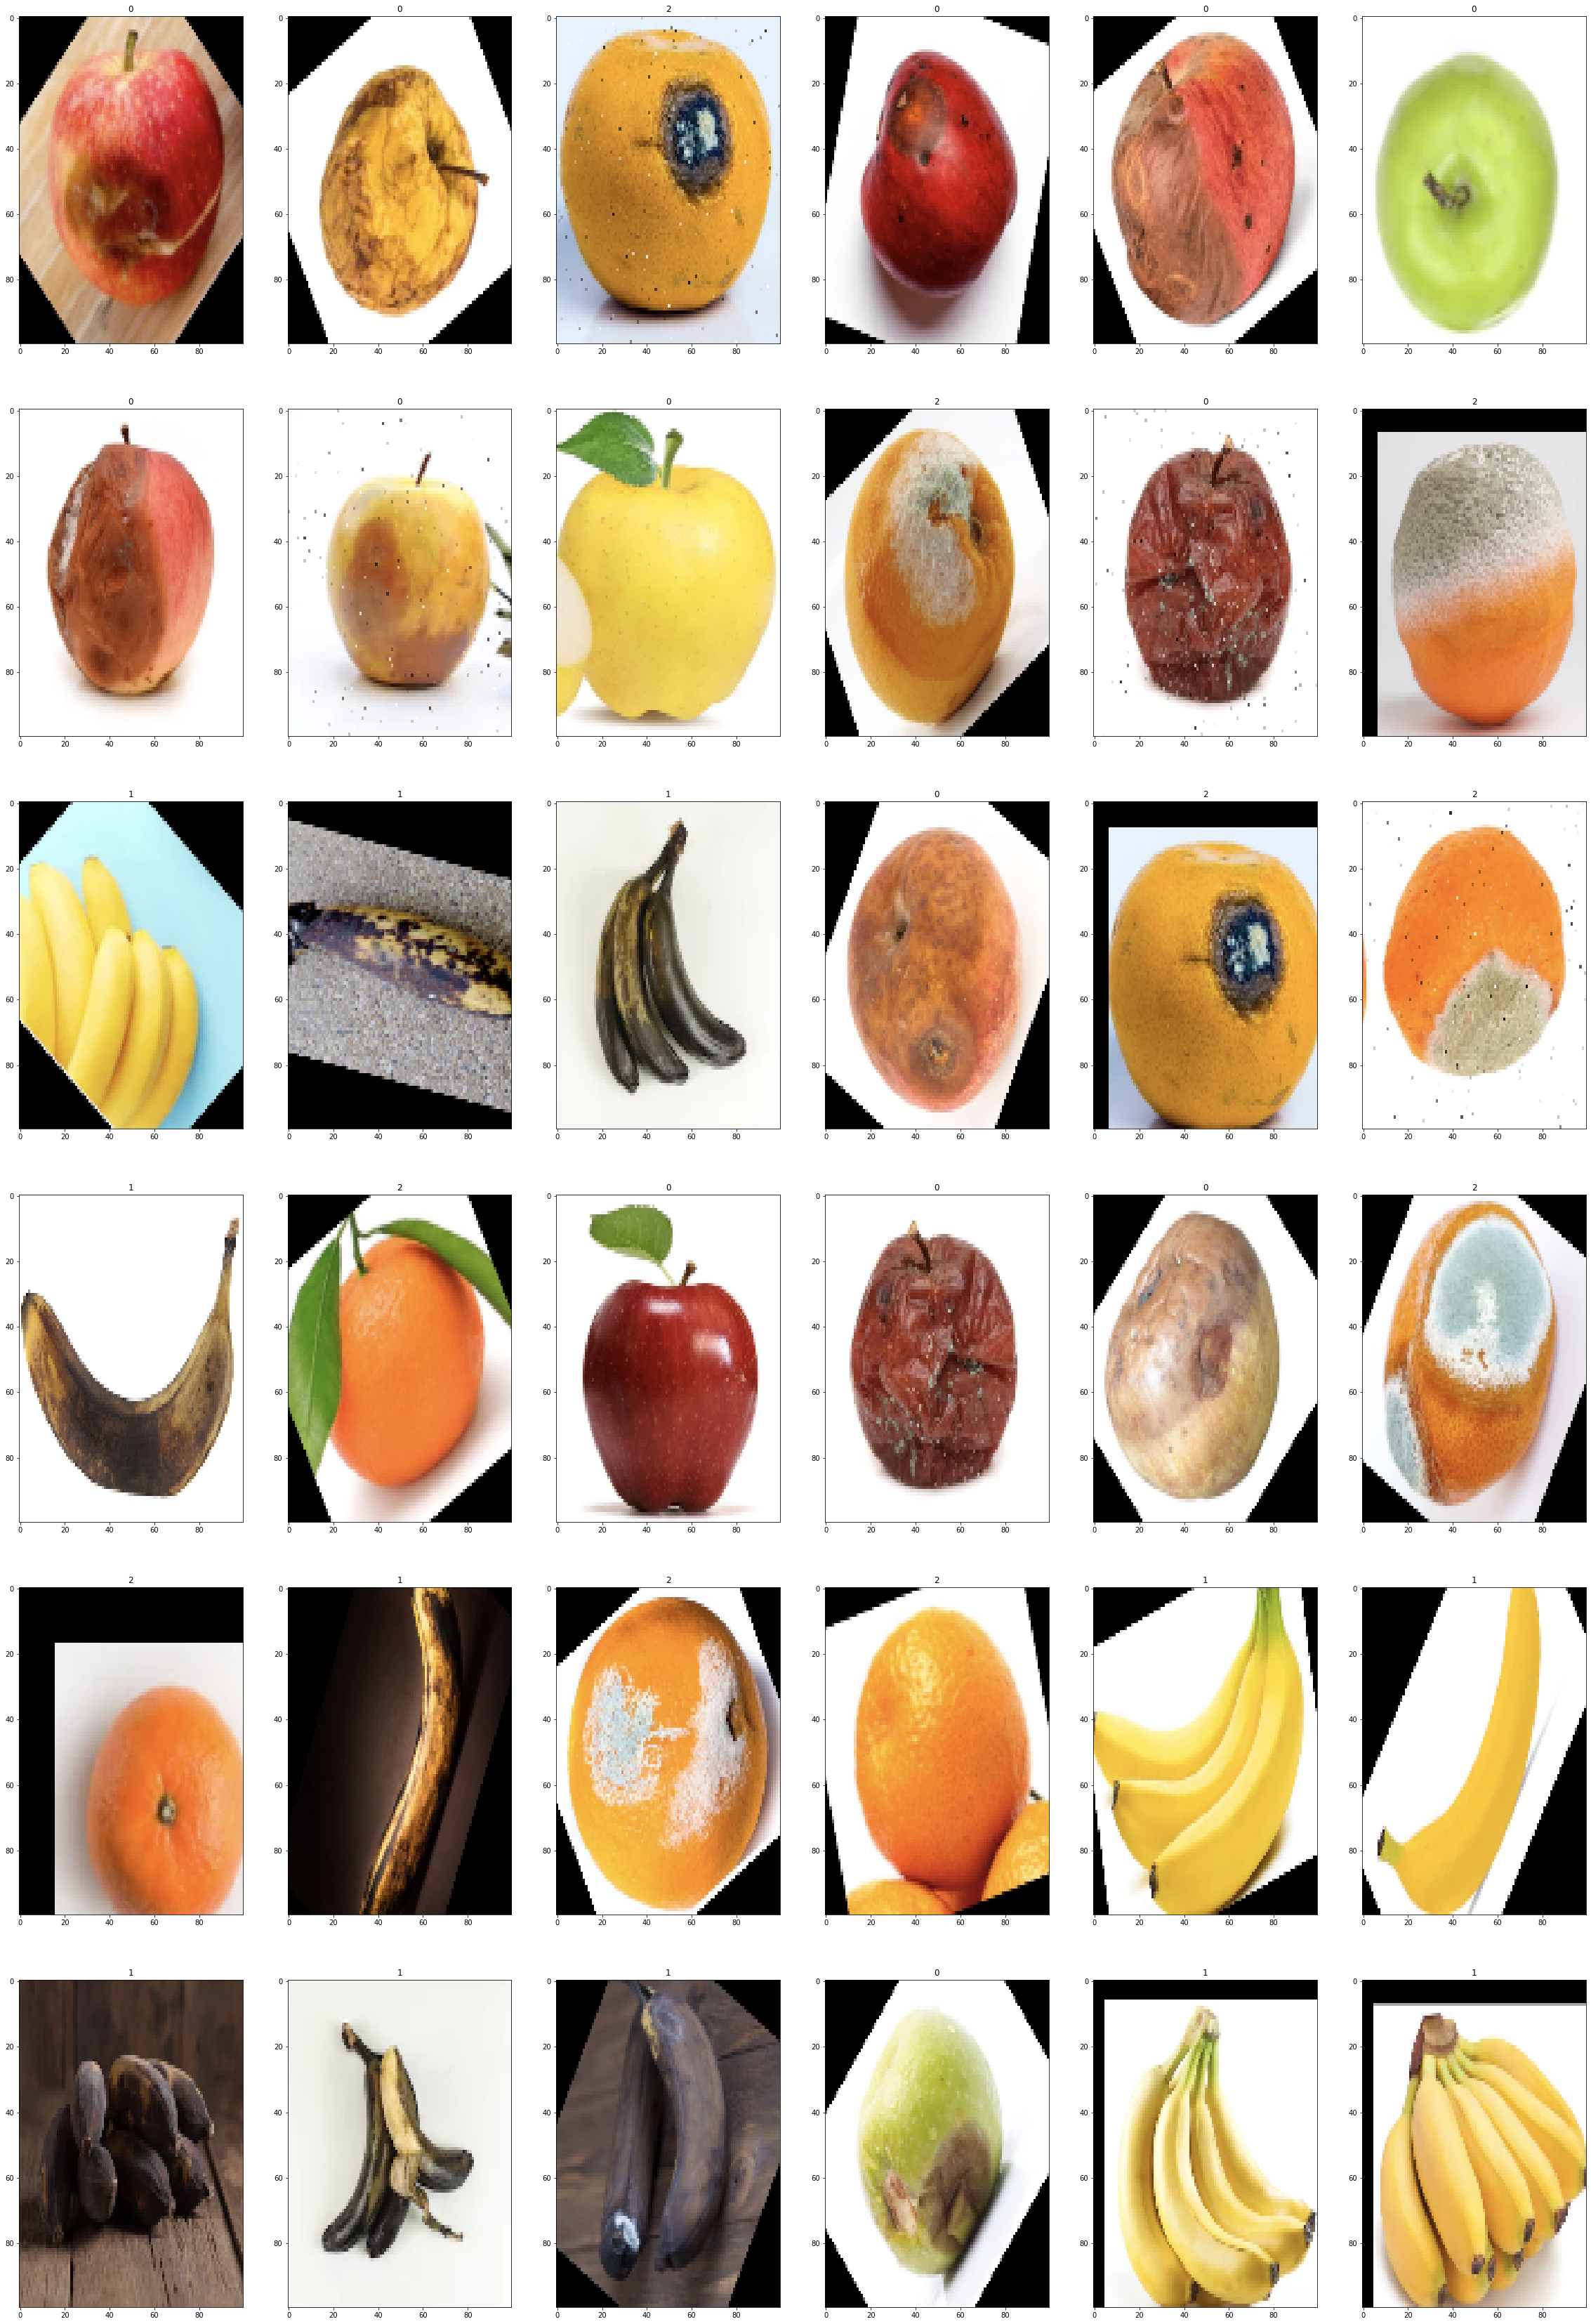

In [50]:
show_subpot(X_val[:36],title=True,Y=np.argmax((model.predict(X_val[:36])), axis=1))

In [52]:
np.argmax((model.predict(X_val[:36])), axis=1)

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0,
       0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)